In [ ]:
# Labelbox
labelbox_dir = "./data/labelbox"
labelbox_clouds_dir = f'{labelbox_dir}/clouds'
labelbox_clouds_rgb_dir = f'{labelbox_clouds_dir}/rgb'
labelbox_clouds_source_dir = f'{labelbox_clouds_dir}/source'
labelbox_clouds_training_dir = f'{labelbox_clouds_dir}/training'
labelbox_clouds_training_labels_dir = f'{labelbox_clouds_training_dir}/labels'

# Radiant Earth
re_cloud_dir = "./data/radiantEarth/clouds"

## Labelbox and custom cloud data

### Create patches from S2 imagery

In [31]:
%reload_ext autoreload
%autoreload 2

import glob
import multiprocessing
import numpy as np
from patchify import patchify
import rasterio


from common.constants import NODATA_FLOAT32
import common.utilities.imagery as imagery


PATCH_SIZE = 512


def process_scene(scene_dir):
    
    scene = scene_dir.split('/')[-1]
    
    with rasterio.open(f'{scene_dir}/B08.tif') as src:
        if src.width < 512 or src.height < 512:
            return

    stack_data = []
    transform = None
    tif_paths = sorted(glob.glob(f'{scene_dir}/B*.tif'))
    for path in tif_paths:
        with rasterio.open(path) as src:
            transform = src.transform
            stack_data.append(src.read(1))

    stack_data = np.ma.array(stack_data)
    stack_data = imagery.normalize_3d_array(stack_data).transpose((1, 2, 0))
        
    source_patches = patchify(stack_data, (PATCH_SIZE, PATCH_SIZE, stack_data.shape[2]), step=PATCH_SIZE)
    
    for irow in range(source_patches.shape[0]):
        for icol in range(source_patches.shape[1]):
            source_data = source_patches[irow, icol, 0, :, :, :]            
            source_data = np.ma.array(source_data, mask=(source_data==NODATA_FLOAT32))
            
            if source_data.mask.sum() > 0:
                print('skipping:', irow, icol)
                continue
            
            rgb_data = source_data[:, :, [2, 1, 0]]
            rgb_data_norm = (rgb_data * 254).astype(np.uint8)
            rgb_data_norm[rgb_data_norm > 254] = 254
                       
            source_path = f'{labelbox_clouds_source_dir}/{scene}_{irow}_{icol}.tif'
            rgb_path = f'{labelbox_clouds_rgb_dir}/{scene}_{irow}_{icol}.tif'
                    
            x_min, y_min = rasterio.transform.xy(transform, PATCH_SIZE*(irow+1), PATCH_SIZE*icol)
            x_max, y_max = rasterio.transform.xy(transform, PATCH_SIZE*irow, PATCH_SIZE*(icol+1))             
            bbox = [x_min, y_min, x_max, y_max]
            
            imagery.write_array_to_tif(rgb_data_norm, rgb_path, bbox, dtype=np.uint8, nodata=255, is_cog=True) 
            imagery.write_array_to_tif(source_data, source_path, bbox, dtype=np.float32, nodata=NODATA_FLOAT32) 
                       
            
scene_dirs = glob.glob(f'./data/20*/S2*')
print(f'{len(scene_dirs)} scenes')
with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
    patches = pool.map(process_scene, scene_dirs)
    

103 scenes


In [21]:
%%bash

# gdalinfo -stats ./data/labelbox/clouds/source/S2A_35MQV_20200731_0_L2A_0_0.tif

### Upload custom patches to S3

In [33]:
%reload_ext autoreload
%autoreload 2

import common.constants as constants
import common.aws.s3 as s3_utils


def save_patch_to_s3(tif_path):
    
    file_name = tif_path.split('/')[-1]    
    object_key = f'clouds/{file_name}'
    href = f'https://data.smartcarte.earth/{object_key}'
    # print(f'uploading {tif_path} to s3://{constants.S3_DATA_BUCKET}/{object_key}')
    s3_utils.put_item(tif_path, constants.S3_DATA_BUCKET, object_key)
    
    return href


In [34]:
import glob
import shelve


state_path = "./data/trainCloudsState"
with shelve.open(state_path) as state:

    rgb_paths = glob.glob(f'{labelbox_clouds_rgb_dir}/*.tif')
    rgb_paths = [path for path in rgb_paths if not path.endswith("deg.tif")]

    for i, path in enumerate(rgb_paths):
        
        if i % 200 == 0:
            print(f'{i} done')
            
        job_name = path.split('/')[-1].replace('.tif', '')
        s3_href = save_patch_to_s3(path)
        state[job_name] = {
            'rgb_cog_href': s3_href
        }
    

0 done
200 done
400 done
600 done
800 done
1000 done
1200 done
1400 done
1600 done
1800 done
2000 done
2200 done
2400 done
2600 done
2800 done
3000 done
3200 done
3400 done
3600 done


### Create custom dataset in Labelbox

In [ ]:
import os

try:
    from common.sagemaker_env import LABELBOX_API_KEY
except: 
    LABELBOX_API_KEY = os.environ['LABELBOX_API_KEY']
    
CLOUD_PROJECT_ID = "cleamnf3q398707ug5s2z4rp6"

In [36]:
import datetime
from labelbox import Client, Dataset, DataRow
import random
import shelve


client = Client(api_key=LABELBOX_API_KEY)
project = client.get_project(CLOUD_PROJECT_ID)

today = datetime.datetime.today().strftime('%Y%m%d')

clouds_dataset_name = f"{today} Clouds"

clouds_dataset = client.get_datasets(where=(Dataset.name==clouds_dataset_name)).get_one()
if clouds_dataset is None:
    clouds_dataset = client.create_dataset(name=clouds_dataset_name)
else:
    raise ValueError("today's clouds dataset already exists")

    
payload = []
with shelve.open(state_path) as state:
    for job_name in state.keys():        
        row = {
            "min_zoom": 12,
            "max_zoom": 14,
            "tile_layer_url": state[job_name]["rgb_cog_href"]
        }
        
        payload.append(row)


payload = [{DataRow.row_data: row} for row in payload]

random.seed(666)
random.shuffle(payload)

start_idx, end_idx = 0, 1000
payload = payload[start_idx:end_idx]

print(f'{len(payload)} data rows')
task = clouds_dataset.create_data_rows(payload)
task.wait_till_done()

print('done')

1000 data rows
done


### Pull results data from Labelbox and create label TIFFs

In [7]:
from datetime import datetime, timedelta
from labelbox import Client


def get_data_rows():
    client = Client(api_key=LABELBOX_API_KEY)
    project = client.get_project(CLOUD_PROJECT_ID)
    data_rows = project.export_labels(download=True)  
    return data_rows


def is_island(target_polygon, polygon_list):
    for curr_poly in polygon_list:
        if target_polygon.within(curr_poly):
            return True
    return False


69 done data rows
done


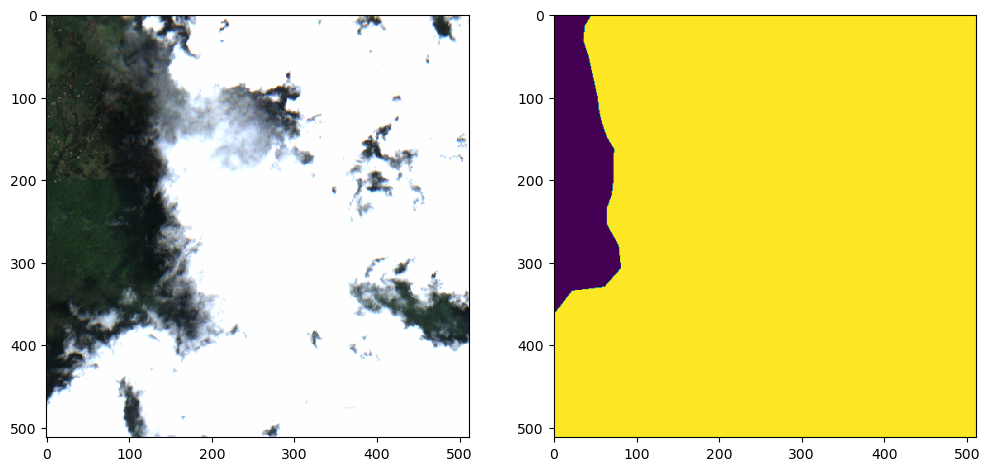

In [10]:
import json
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Polygon


from common.utilities.imagery import write_array_to_tif
from common.utilities.visualization import plot_bands


CLOUD_CLASSES = {
    'no_cloud': 0,
    'cloud': 1
}

data_rows = get_data_rows()
# filter rows that are done
data_rows = [dr for dr in data_rows if dr['DataRow Workflow Info']['taskName'] == "Done"]
print(f'{len(data_rows)} done data rows')

for i, row in enumerate(data_rows):
        
    row_id = row['DataRow ID']
    labels = row['Label']['objects']
    metadata = json.loads(row['Labeled Data'])
    rgb_cog_url = metadata['tileLayerUrl']
    job_name = rgb_cog_url.split('/')[-1].replace('.tif', '')
    
    rgb_path = f'{labelbox_clouds_rgb_dir}/{job_name}.tif'
    composite_path = f'{labelbox_clouds_source_dir}/{job_name}.tif'
    label_path = f'{labelbox_clouds_training_labels_dir}/{job_name}.tif'

    with rasterio.open(composite_path) as src:
        bbox = list(src.bounds)
        composite_shape = src.shape
        composite_transform = src.transform
    
    label_polygons = {
        label['featureId']: Polygon(label['geometry']['coordinates'][0])
        for label in labels
    }
        
    # 0: no_cloud, 1: cloud
    labels_data = np.zeros(composite_shape).astype(np.uint8)
    
    islands = []    
    sorted_labels = sorted(labels, key=lambda lab: lab['value'], reverse=True)   
    for label in sorted_labels:
        class_value = label['value']
        class_idx = CLOUD_CLASSES[class_value]
                
        label_id = label['featureId']
        polygon = label_polygons[label_id]
        polygon_mask = geometry_mask([polygon], composite_shape, composite_transform, invert=True)
        
        test_polygons = label_polygons.copy()
        del test_polygons[label_id]
        is_poly_island = is_island(polygon, list(test_polygons.values()))
                
        if is_poly_island:
            islands.append((class_idx, polygon_mask))
        else:
            labels_data[polygon_mask] = class_idx

    
    for class_idx, polygon_mask in islands:
        labels_data[polygon_mask] = class_idx
          
    write_array_to_tif(labels_data, label_path, bbox, dtype=np.uint8, nodata=255)

    # plot
    if i == 53:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
        with rasterio.open(rgb_path) as src:
            data = src.read()
            plot_bands(data, ax=ax1, bands=[0, 1, 2], transpose=True)

        ax2.imshow(labels_data, vmin=0, vmax=1)
       
        
print('done')

### Data augmentation by rotating Labelbox cloud TIFFs

In [11]:
%reload_ext autoreload
%autoreload 2

import glob
import numpy as np
import rasterio
import shutil

from common.constants import NODATA_BYTE, NODATA_FLOAT32
import common.utilities.imagery as imagery


label_paths = glob.glob(f'{labelbox_clouds_training_labels_dir}/S2*[0-9].tif')

for label_path in label_paths:
    rgb_path = label_path.replace(labelbox_clouds_training_labels_dir, labelbox_clouds_rgb_dir)
    source_path = label_path.replace(labelbox_clouds_training_labels_dir, labelbox_clouds_source_dir)
        
    with rasterio.open(source_path) as source_src:
        source_data = source_src.read()
        bbox = list(source_src.bounds)
        
    with rasterio.open(rgb_path) as rgb_src:
        rgb_data = rgb_src.read()
        
    with rasterio.open(label_path) as label_src:
        label_data = label_src.read(1)
          
    # copy source and rgb tiffs to training subdirectory
    rgb_target_path = label_path.replace('/labels/', '/rgb/')
    source_target_path = label_path.replace('/labels/', '/source/')

    shutil.copy2(rgb_path, rgb_target_path)
    shutil.copy2(source_path, source_target_path)

    # imagery.write_array_to_tif(rgb_data.transpose((1, 2, 0)), rgb_target_path, bbox, dtype=np.float32, nodata=NODATA_FLOAT32)
    # imagery.write_array_to_tif(source_data.transpose((1, 2, 0)), source_target_path, bbox, dtype=np.float32, nodata=NODATA_FLOAT32)
                    
    for i in range(1, 4):
        
        source_rotated = np.rot90(source_data, k=i, axes=(1, 2))
        source_rotated = source_rotated.transpose((1, 2, 0))
        
        rgb_rotated = np.rot90(rgb_data, k=i, axes=(1, 2))
        rgb_rotated = rgb_rotated.transpose((1, 2, 0))
        
        label_rotated = np.rot90(label_data, k=i, axes=(0, 1))
        
        source_rotated_path = source_target_path.replace('.tif', f'_{i*90}deg.tif')
        rgb_rotated_path = rgb_target_path.replace('.tif', f'_{i*90}deg.tif')
        label_rotated_path = label_path.replace('.tif', f'_{i*90}deg.tif')
                
        imagery.write_array_to_tif(source_rotated, source_rotated_path, bbox, dtype=np.float32, nodata=NODATA_FLOAT32)
        imagery.write_array_to_tif(rgb_rotated, rgb_rotated_path, bbox, dtype=np.float32, nodata=NODATA_FLOAT32)
        imagery.write_array_to_tif(label_rotated, label_rotated_path, bbox, dtype=np.uint8, nodata=NODATA_BYTE)     
        
print('done')

## Radiant Earth cloud data

In [ ]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import os
from pystac_client import Client
import rasterio
import requests
import shutil

from common.constants import NODATA_FLOAT32
from common.sagemaker_env import RADIANT_EARTH_API_KEY
import common.utilities.imagery as imagery


client = Client.open("https://api.radiant.earth/mlhub/v1", parameters={"key": RADIANT_EARTH_API_KEY})

collections = [
        'ref_cloud_cover_detection_challenge_v1_train_source',
        'ref_cloud_cover_detection_challenge_v1_train_labels',
        'ref_cloud_cover_detection_challenge_v1_test_source',
        'ref_cloud_cover_detection_challenge_v1_test_labels',
]


for collection_id in collections:

    role = collection_id.split('_')[-1]
    stage = collection_id.split('_')[-2]
    items_dir = f'{re_cloud_dir}/{role}'
    os.makedirs(items_dir, exist_ok=True)

    print(collection_id, items_dir)
    
    collection = client.get_collection(collection_id)
    results = collection.get_items()
        
    for i, item in enumerate(results):

        chip_id = item.id.split('_')[-1] # chip_id
        chip_path = f'{items_dir}/{chip_id}.tif'
        chip_90deg_path = f'{items_dir}/{chip_id}_90deg.tif'

        if i % 50 == 0:
            print(f'\t{i} chips done')
            
        if i == 150:
            break
            
        if os.path.exists(chip_path):
            
            # rotate images 90 degrees
            if not os.path.exists(chip_90deg_path):
                with rasterio.open(chip_path) as src:
                    bbox = list(src.bounds)
                    if role == "source":
                        data = src.read()
                        data_90deg = np.rot90(data, axes=(1, 2)).transpose((1, 2, 0))
                        imagery.write_array_to_tif(data_90deg, chip_90deg_path, bbox, dtype=np.float32, nodata=NODATA_FLOAT32)
                    elif role == "labels":
                        data = src.read(1)
                        data_90deg = np.rot90(data, axes=(0, 1))
                        imagery.write_array_to_tif(data_90deg, chip_90deg_path, bbox, dtype=np.uint8, nodata=255)
                        
            continue
            
        while True:
            try:
                if role == "labels":
                    asset_href = item.assets['raster_labels'].href
                    response = requests.get(asset_href)
                    with open(chip_path, 'wb') as f:
                        f.write(response.content)

                else:
                    temp_dir = f'{items_dir}/{chip_id}_temp'
                    os.makedirs(temp_dir, exist_ok=True)
                    
                    band_paths = []
                    for band in item.assets:
                        band_path = f'{temp_dir}/{band}.tif'                
                        band_paths.append(band_path)
                        band_href = item.assets[band].href
                        response = requests.get(band_href)
                        with open(band_path, 'wb') as f:
                            f.write(response.content)
                                                        
                    stack_data = []
                    bbox, epsg = None, 4326
                    for path in band_paths:
                        with rasterio.open(path) as src:
                            stack_data.append(src.read(1))
                            bbox = list(src.bounds)
                            epsg = src.crs.to_epsg()                       
                                                        
                    stack_data = np.array(stack_data).astype(np.float32)
                    stack_data = imagery.normalize_original_s2_array(stack_data)
                    stack_data = stack_data.transpose((1, 2, 0))
                    imagery.write_array_to_tif(stack_data, chip_path, bbox, dtype=np.float32, epsg=epsg, nodata=NODATA_FLOAT32) 
                                
                    shutil.rmtree(temp_dir)
                    
                break
                    
            except Exception as e:
                print('error:', e)
                raise
                
print('done')

## Merge Labelbox and Radiant Earth datasets

In [12]:

merged_original_dir = "./data/mergedCloudTrainingData/original"
merged_split_dir = "./data/mergedCloudTrainingData/split"

In [13]:
import glob
import multiprocessing
import os
import shutil



os.makedirs(f'{merged_original_dir}/source', exist_ok=True)
os.makedirs(f'{merged_original_dir}/labels', exist_ok=True)
os.makedirs(merged_split_dir, exist_ok=True)


def process_label_path(path):
    file_name = path.split('/')[-1]
    dst_path = f'{merged_original_dir}/labels/{file_name}'
    shutil.copy2(path, dst_path)

    
def process_source_path(path):
    file_name = path.split('/')[-1]
    dst_path = f'{merged_original_dir}/source/{file_name}'
    shutil.copy2(path, dst_path)

    
all_cloud_dirs = [labelbox_clouds_training_dir, re_cloud_dir]    
for _dir in all_cloud_dirs:
    print(_dir)
    
    label_paths = glob.glob(f'{_dir}/labels/*.tif')            
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        pool.map(process_label_path, label_paths)

    source_paths = [p.replace('/labels/', '/source/') for p in label_paths]
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        pool.map(process_source_path, source_paths)

print('done')

./data/labelbox/clouds/training
./data/radiantEarth/clouds
done


## Split data into training / val / test

In [14]:
import os
import shutil
import splitfolders


if os.path.exists(merged_split_dir):
    shutil.rmtree(merged_split_dir)

splitfolders.ratio(merged_original_dir, output=merged_split_dir, seed=666, ratio=(0.80, 0.10, 0.10), group_prefix=None);

print('done')

Copying files: 3752 files [03:49, 16.33 files/s]

done
